In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'uni95'
train_type = "large"

In [4]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 396
Categorical features: 10
Text features: 0


In [5]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=True,
    scale_type='minmax',
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 468
Categorical Columns: 10


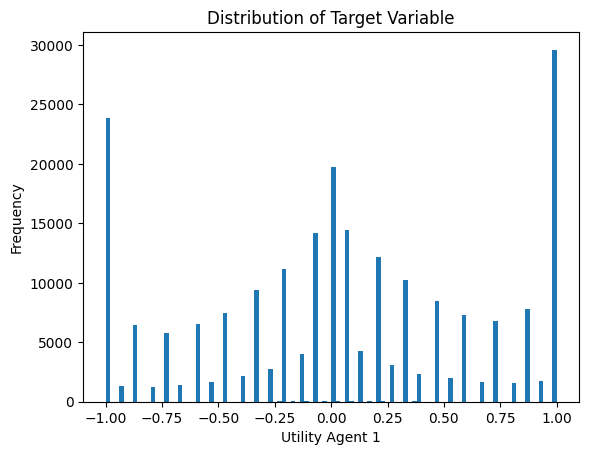

In [6]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [7]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [8]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.05
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.025
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.025 10000


In [9]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        # 'boosting': 'dart',
        # 'drop_rate': 0.1,
        # 'max_drop': 50,
        # 'skip_drop': 0.6,
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        #'extra_trees': True,
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        #'reg_alpha': 1e-1,
        #'reg_lambda': 1e-1,
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,

        'linear_tree': True,
        'linear_lambda': 1e-1,
        
        #'cat_l2': 1.,
        #'max_cat_threshold': 32
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1
[100]	valid_0's rmse: 0.48695
[200]	valid_0's rmse: 0.470222
[300]	valid_0's rmse: 0.461289
[400]	valid_0's rmse: 0.454976
[500]	valid_0's rmse: 0.450284
[600]	valid_0's rmse: 0.446459
[700]	valid_0's rmse: 0.443637
[800]	valid_0's rmse: 0.441518
[900]	valid_0's rmse: 0.439524
[1000]	valid_0's rmse: 0.438341
[1100]	valid_0's rmse: 0.436988
[1200]	valid_0's rmse: 0.436142
[1300]	valid_0's rmse: 0.435548
[1400]	valid_0's rmse: 0.434665
[1500]	valid_0's rmse: 0.434034
[1600]	valid_0's rmse: 0.433508
[1700]	valid_0's rmse: 0.432859
[1800]	valid_0's rmse: 0.432442
[1900]	valid_0's rmse: 0.431942
[2000]	valid_0's rmse: 0.431661
[2100]	valid_0's rmse: 0.431339
[2200]	valid_0's rmse: 0.431072
[2300]	valid_0's rmse: 0.430866
[2400]	valid_0's rmse: 0.430727
[2500]	valid_0's rmse: 0.43068
[2600]	valid_0's rmse: 0.430504
[2700]	valid_0's rmse: 0.43032
[2800]	valid_0's rmse: 0.430059
[2900]	valid_0's rmse: 0.429668
[3000]	valid_0's rmse: 0.429652
[3100]	valid_0's rmse: 0.4295
[3200]	valid_0'

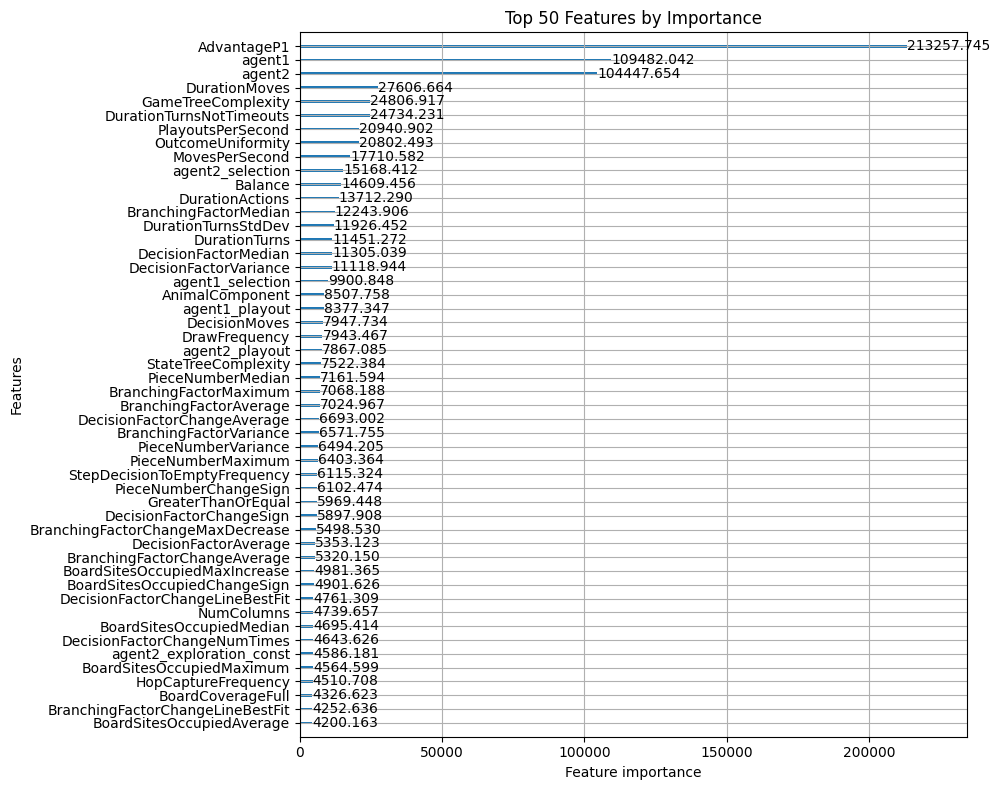

Fold 1 - RMSE: 0.42655828272198176
Fold 2
[100]	valid_0's rmse: 0.50632
[200]	valid_0's rmse: 0.48963
[300]	valid_0's rmse: 0.481592
[400]	valid_0's rmse: 0.475605
[500]	valid_0's rmse: 0.471875
[600]	valid_0's rmse: 0.469648
[700]	valid_0's rmse: 0.467707
[800]	valid_0's rmse: 0.466137
[900]	valid_0's rmse: 0.464684
[1000]	valid_0's rmse: 0.463591
[1100]	valid_0's rmse: 0.462507
[1200]	valid_0's rmse: 0.461658
[1300]	valid_0's rmse: 0.461178
[1400]	valid_0's rmse: 0.460625
[1500]	valid_0's rmse: 0.460209
[1600]	valid_0's rmse: 0.459677
[1700]	valid_0's rmse: 0.459085
[1800]	valid_0's rmse: 0.458592
[1900]	valid_0's rmse: 0.458219
[2000]	valid_0's rmse: 0.457824
[2100]	valid_0's rmse: 0.457476
[2200]	valid_0's rmse: 0.457148
[2300]	valid_0's rmse: 0.456754
[2400]	valid_0's rmse: 0.456556
[2500]	valid_0's rmse: 0.456295
[2600]	valid_0's rmse: 0.45585
[2700]	valid_0's rmse: 0.455729
[2800]	valid_0's rmse: 0.455565
[2900]	valid_0's rmse: 0.455385
[3000]	valid_0's rmse: 0.455289
[3100]	val

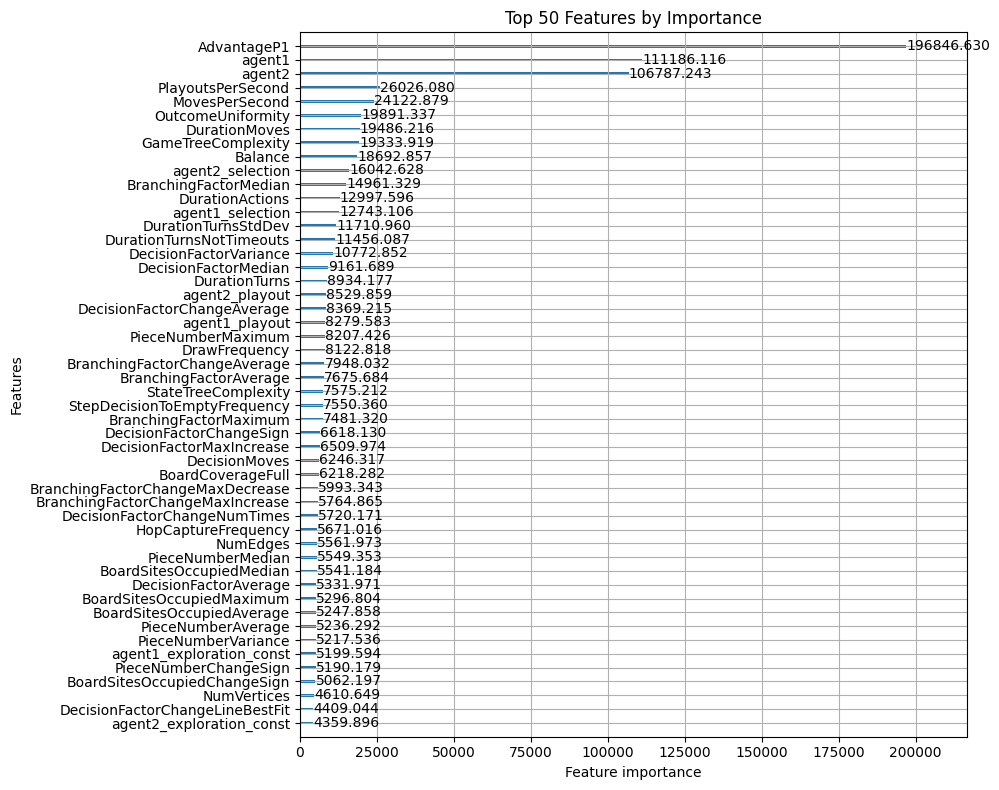

Fold 2 - RMSE: 0.4507539862497782
Fold 3
[100]	valid_0's rmse: 0.506996
[200]	valid_0's rmse: 0.48083
[300]	valid_0's rmse: 0.471469
[400]	valid_0's rmse: 0.467422
[500]	valid_0's rmse: 0.464361
[600]	valid_0's rmse: 0.462535
[700]	valid_0's rmse: 0.460401
[800]	valid_0's rmse: 0.458515
[900]	valid_0's rmse: 0.457168
[1000]	valid_0's rmse: 0.456098
[1100]	valid_0's rmse: 0.454983
[1200]	valid_0's rmse: 0.454232
[1300]	valid_0's rmse: 0.453544
[1400]	valid_0's rmse: 0.45275
[1500]	valid_0's rmse: 0.452127
[1600]	valid_0's rmse: 0.451602
[1700]	valid_0's rmse: 0.451285
[1800]	valid_0's rmse: 0.450876
[1900]	valid_0's rmse: 0.450563
[2000]	valid_0's rmse: 0.450278
[2100]	valid_0's rmse: 0.450039
[2200]	valid_0's rmse: 0.449797
[2300]	valid_0's rmse: 0.449577
[2400]	valid_0's rmse: 0.44927
[2500]	valid_0's rmse: 0.44915
[2600]	valid_0's rmse: 0.449032
[2700]	valid_0's rmse: 0.448883
[2800]	valid_0's rmse: 0.448839
[2900]	valid_0's rmse: 0.448545
[3000]	valid_0's rmse: 0.448547
[3100]	valid

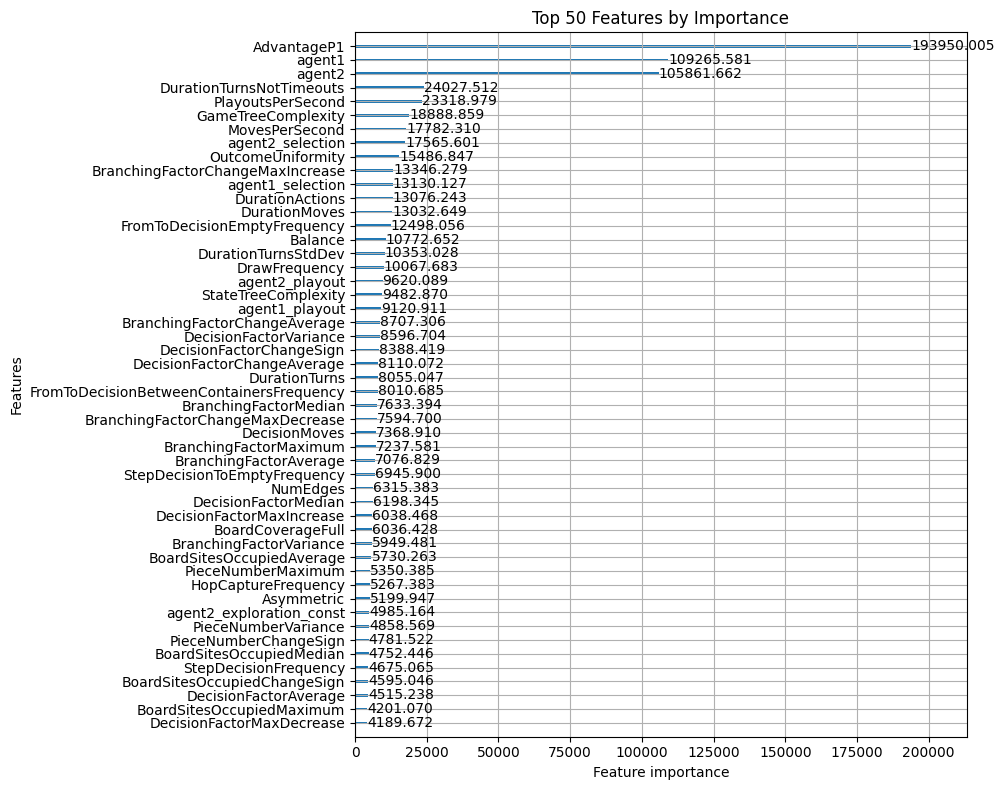

Fold 3 - RMSE: 0.44627289973120404
Fold 4
[100]	valid_0's rmse: 0.505032
[200]	valid_0's rmse: 0.484239
[300]	valid_0's rmse: 0.473054
[400]	valid_0's rmse: 0.466123
[500]	valid_0's rmse: 0.461685
[600]	valid_0's rmse: 0.458527
[700]	valid_0's rmse: 0.456216
[800]	valid_0's rmse: 0.453665
[900]	valid_0's rmse: 0.451797
[1000]	valid_0's rmse: 0.450552
[1100]	valid_0's rmse: 0.449565
[1200]	valid_0's rmse: 0.448481
[1300]	valid_0's rmse: 0.447756
[1400]	valid_0's rmse: 0.447089
[1500]	valid_0's rmse: 0.446674
[1600]	valid_0's rmse: 0.44614
[1700]	valid_0's rmse: 0.445568
[1800]	valid_0's rmse: 0.445076
[1900]	valid_0's rmse: 0.444555
[2000]	valid_0's rmse: 0.444198
[2100]	valid_0's rmse: 0.443798
[2200]	valid_0's rmse: 0.443441
[2300]	valid_0's rmse: 0.443288
[2400]	valid_0's rmse: 0.443053
[2500]	valid_0's rmse: 0.442858
[2600]	valid_0's rmse: 0.442686
[2700]	valid_0's rmse: 0.442416
[2800]	valid_0's rmse: 0.442119
[2900]	valid_0's rmse: 0.441975
[3000]	valid_0's rmse: 0.441732
[3100]	v

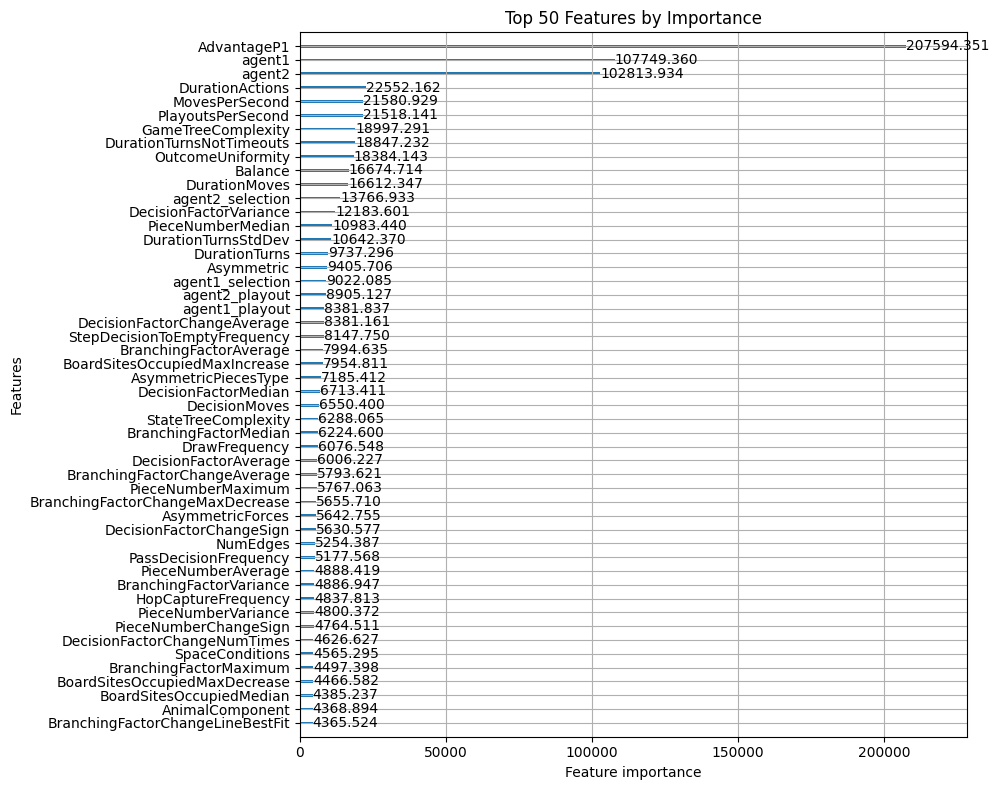

Fold 4 - RMSE: 0.43650172497412787
Fold 5
[100]	valid_0's rmse: 0.479126
[200]	valid_0's rmse: 0.45724
[300]	valid_0's rmse: 0.447399
[400]	valid_0's rmse: 0.43998
[500]	valid_0's rmse: 0.435299
[600]	valid_0's rmse: 0.432042
[700]	valid_0's rmse: 0.429376
[800]	valid_0's rmse: 0.427147
[900]	valid_0's rmse: 0.425649
[1000]	valid_0's rmse: 0.424332
[1100]	valid_0's rmse: 0.422868
[1200]	valid_0's rmse: 0.421846
[1300]	valid_0's rmse: 0.420919
[1400]	valid_0's rmse: 0.420073
[1500]	valid_0's rmse: 0.419492
[1600]	valid_0's rmse: 0.418874
[1700]	valid_0's rmse: 0.418219
[1800]	valid_0's rmse: 0.417604
[1900]	valid_0's rmse: 0.417097
[2000]	valid_0's rmse: 0.416713
[2100]	valid_0's rmse: 0.416268
[2200]	valid_0's rmse: 0.415987
[2300]	valid_0's rmse: 0.415759
[2400]	valid_0's rmse: 0.415355
[2500]	valid_0's rmse: 0.415255
[2600]	valid_0's rmse: 0.415002
[2700]	valid_0's rmse: 0.414957
[2800]	valid_0's rmse: 0.414617
[2900]	valid_0's rmse: 0.414335
[3000]	valid_0's rmse: 0.413852
[3100]	va

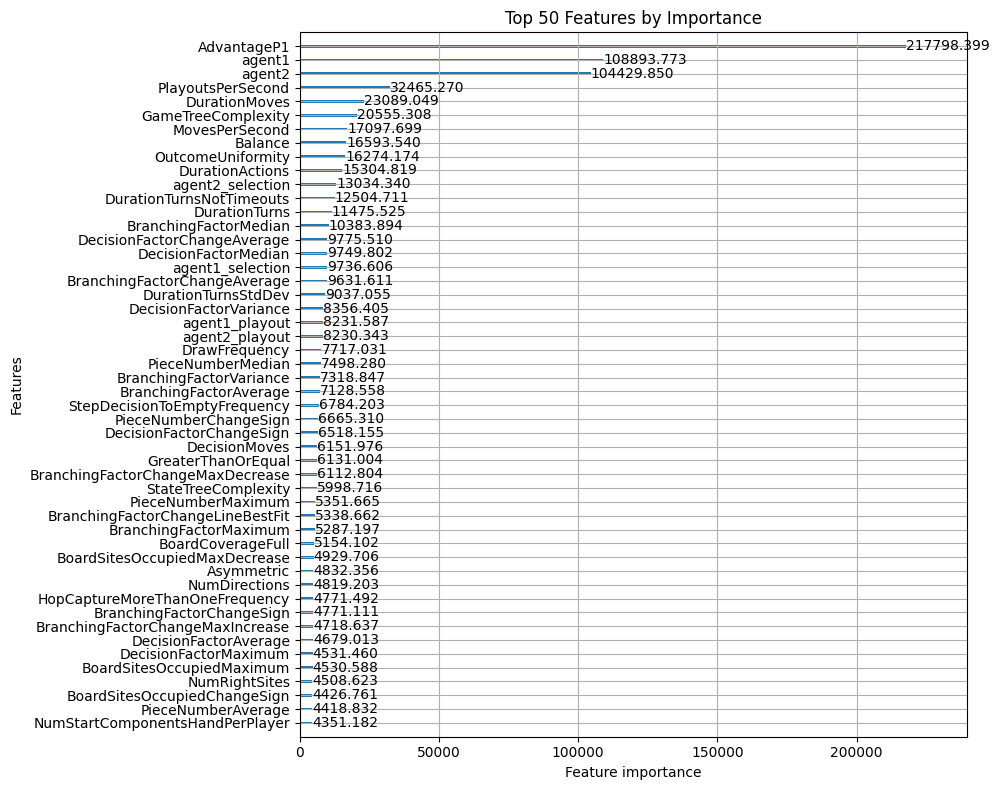

Fold 5 - RMSE: 0.41000699279281944
List of oof scores: [0.42655828272198176, 0.4507539862497782, 0.44627289973120404, 0.43650172497412787, 0.41000699279281944]
Average oof score: 0.43401877729398225


In [10]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_linear_{fs_type}_cv1.parquet', index=False)

In [11]:
# 0.4340 (medium)
# 0.4383
# 0.4285 (best)
# 0.4316


Fold 1
[100]	valid_0's rmse: 0.471572
[200]	valid_0's rmse: 0.455004
[300]	valid_0's rmse: 0.447795
[400]	valid_0's rmse: 0.443693
[500]	valid_0's rmse: 0.440305
[600]	valid_0's rmse: 0.437921
[700]	valid_0's rmse: 0.435776
[800]	valid_0's rmse: 0.433673
[900]	valid_0's rmse: 0.431972
[1000]	valid_0's rmse: 0.430728
[1100]	valid_0's rmse: 0.429412
[1200]	valid_0's rmse: 0.428694
[1300]	valid_0's rmse: 0.428039
[1400]	valid_0's rmse: 0.427285
[1500]	valid_0's rmse: 0.426729
[1600]	valid_0's rmse: 0.426081
[1700]	valid_0's rmse: 0.42557
[1800]	valid_0's rmse: 0.425166
[1900]	valid_0's rmse: 0.424749
[2000]	valid_0's rmse: 0.424485
[2100]	valid_0's rmse: 0.424026
[2200]	valid_0's rmse: 0.423618
[2300]	valid_0's rmse: 0.423279
[2400]	valid_0's rmse: 0.423073
[2500]	valid_0's rmse: 0.42288
[2600]	valid_0's rmse: 0.422612
[2700]	valid_0's rmse: 0.42235
[2800]	valid_0's rmse: 0.422065
[2900]	valid_0's rmse: 0.421974
[3000]	valid_0's rmse: 0.421836
[3100]	valid_0's rmse: 0.421583
[3200]	valid_

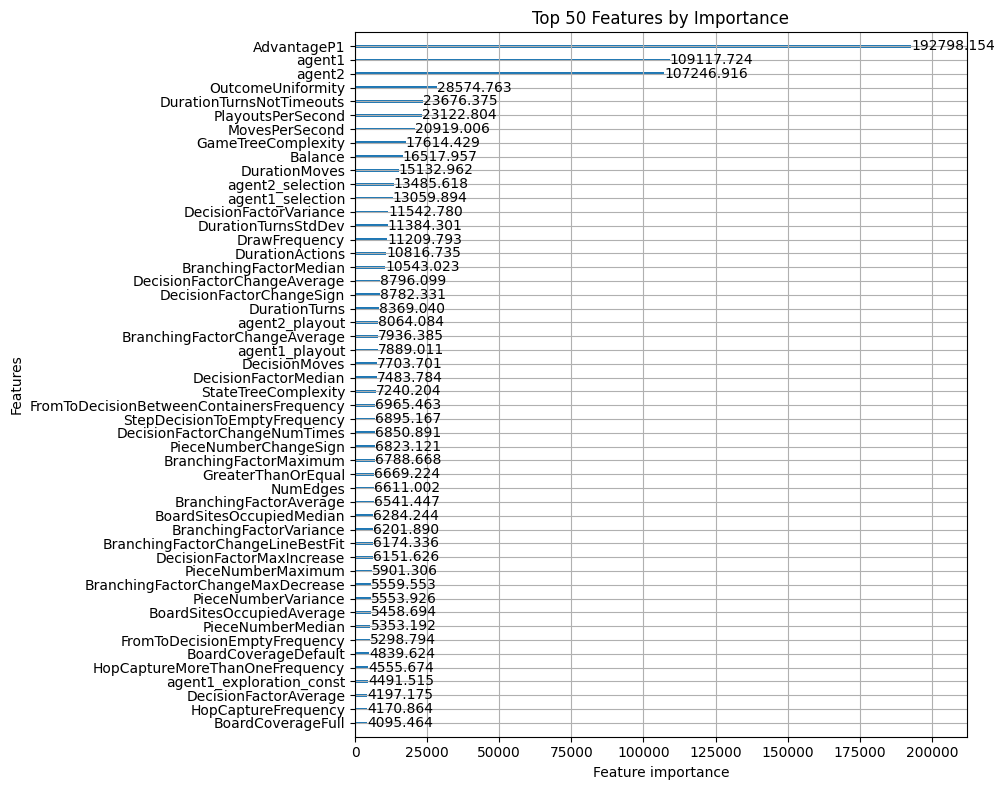

Fold 1 - RMSE: 0.41563091622934395
Fold 2
[100]	valid_0's rmse: 0.455111
[200]	valid_0's rmse: 0.435105
[300]	valid_0's rmse: 0.429041
[400]	valid_0's rmse: 0.424977
[500]	valid_0's rmse: 0.422653
[600]	valid_0's rmse: 0.420042
[700]	valid_0's rmse: 0.418067
[800]	valid_0's rmse: 0.416834
[900]	valid_0's rmse: 0.415651
[1000]	valid_0's rmse: 0.414613
[1100]	valid_0's rmse: 0.414172
[1200]	valid_0's rmse: 0.41328
[1300]	valid_0's rmse: 0.412519
[1400]	valid_0's rmse: 0.411903
[1500]	valid_0's rmse: 0.411737
[1600]	valid_0's rmse: 0.411296
[1700]	valid_0's rmse: 0.410961
[1800]	valid_0's rmse: 0.41063
[1900]	valid_0's rmse: 0.41019
[2000]	valid_0's rmse: 0.409907
[2100]	valid_0's rmse: 0.409699
[2200]	valid_0's rmse: 0.409545
[2300]	valid_0's rmse: 0.409404
[2400]	valid_0's rmse: 0.409214
[2500]	valid_0's rmse: 0.409118
[2600]	valid_0's rmse: 0.408912
[2700]	valid_0's rmse: 0.408799
[2800]	valid_0's rmse: 0.408506
[2900]	valid_0's rmse: 0.408653
[3000]	valid_0's rmse: 0.408583
[3100]	val

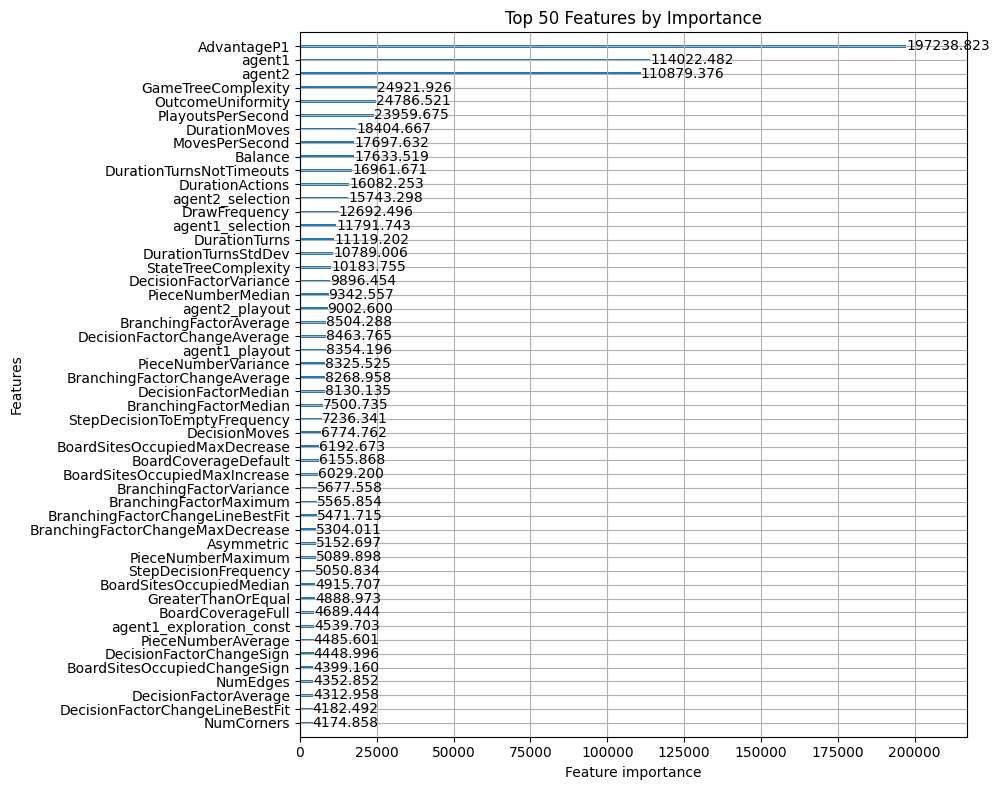

Fold 2 - RMSE: 0.4077334102497926
Fold 3
[100]	valid_0's rmse: 0.513163
[200]	valid_0's rmse: 0.490126
[300]	valid_0's rmse: 0.478234
[400]	valid_0's rmse: 0.470877
[500]	valid_0's rmse: 0.465956
[600]	valid_0's rmse: 0.462184
[700]	valid_0's rmse: 0.459116
[800]	valid_0's rmse: 0.456522
[900]	valid_0's rmse: 0.454197
[1000]	valid_0's rmse: 0.452503
[1100]	valid_0's rmse: 0.451052
[1200]	valid_0's rmse: 0.450108
[1300]	valid_0's rmse: 0.448993
[1400]	valid_0's rmse: 0.448014
[1500]	valid_0's rmse: 0.447232
[1600]	valid_0's rmse: 0.44653
[1700]	valid_0's rmse: 0.445667
[1800]	valid_0's rmse: 0.44502
[1900]	valid_0's rmse: 0.444463
[2000]	valid_0's rmse: 0.443992
[2100]	valid_0's rmse: 0.443617
[2200]	valid_0's rmse: 0.443092
[2300]	valid_0's rmse: 0.44281
[2400]	valid_0's rmse: 0.44235
[2500]	valid_0's rmse: 0.442004
[2600]	valid_0's rmse: 0.441635
[2700]	valid_0's rmse: 0.441452
[2800]	valid_0's rmse: 0.441188
[2900]	valid_0's rmse: 0.440994
[3000]	valid_0's rmse: 0.44079
[3100]	valid_

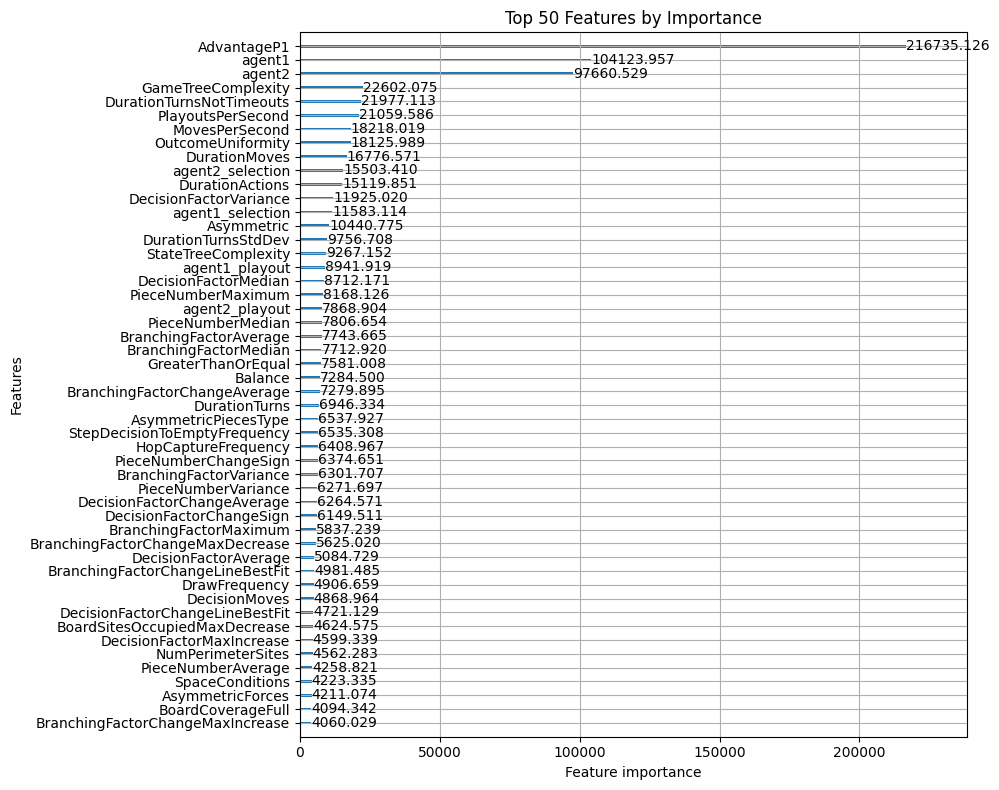

Fold 3 - RMSE: 0.4350919995178272
Fold 4
[100]	valid_0's rmse: 0.505518
[200]	valid_0's rmse: 0.481639
[300]	valid_0's rmse: 0.468597
[400]	valid_0's rmse: 0.462544
[500]	valid_0's rmse: 0.458183
[600]	valid_0's rmse: 0.454574
[700]	valid_0's rmse: 0.45186
[800]	valid_0's rmse: 0.449791
[900]	valid_0's rmse: 0.448312
[1000]	valid_0's rmse: 0.44689
[1100]	valid_0's rmse: 0.445946
[1200]	valid_0's rmse: 0.445091
[1300]	valid_0's rmse: 0.444275
[1400]	valid_0's rmse: 0.443378
[1500]	valid_0's rmse: 0.442737
[1600]	valid_0's rmse: 0.442237
[1700]	valid_0's rmse: 0.441595
[1800]	valid_0's rmse: 0.441139
[1900]	valid_0's rmse: 0.440787
[2000]	valid_0's rmse: 0.44014
[2100]	valid_0's rmse: 0.439935
[2200]	valid_0's rmse: 0.439586
[2300]	valid_0's rmse: 0.439422
[2400]	valid_0's rmse: 0.438938
[2500]	valid_0's rmse: 0.438548
[2600]	valid_0's rmse: 0.438265
[2700]	valid_0's rmse: 0.438011
[2800]	valid_0's rmse: 0.43778
[2900]	valid_0's rmse: 0.437323
[3000]	valid_0's rmse: 0.437075
[3100]	valid

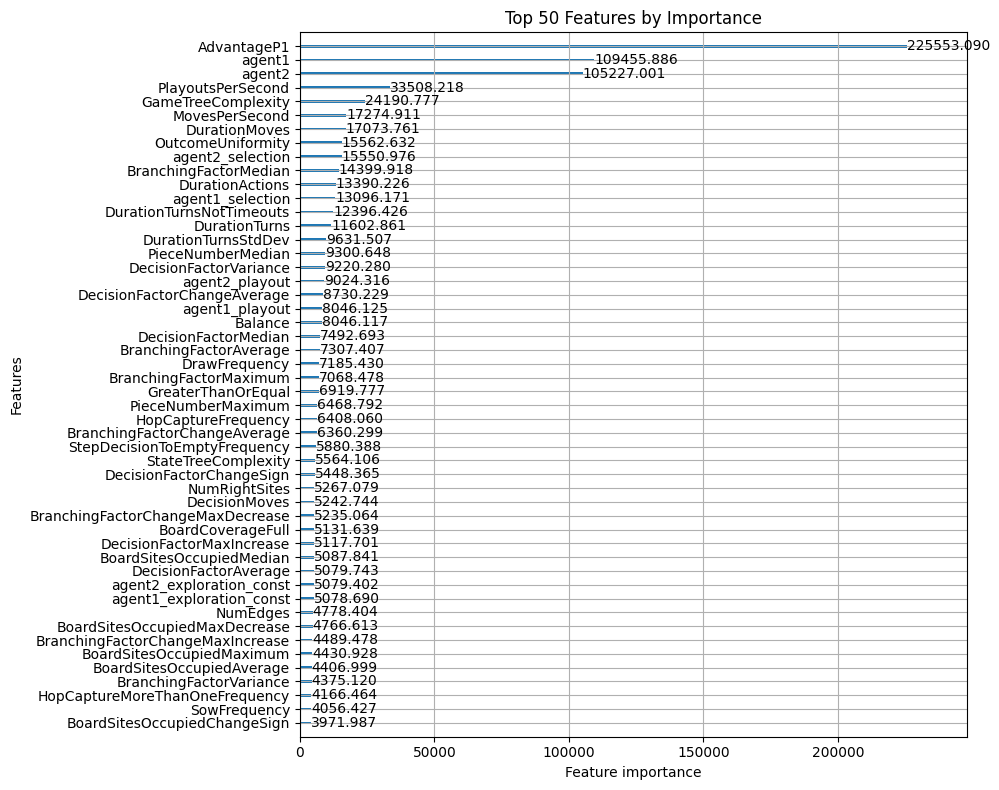

Fold 4 - RMSE: 0.43291897184355554
Fold 5
[100]	valid_0's rmse: 0.511946
[200]	valid_0's rmse: 0.488919
[300]	valid_0's rmse: 0.47645
[400]	valid_0's rmse: 0.468778
[500]	valid_0's rmse: 0.463748
[600]	valid_0's rmse: 0.459197
[700]	valid_0's rmse: 0.456554
[800]	valid_0's rmse: 0.454334
[900]	valid_0's rmse: 0.452044
[1000]	valid_0's rmse: 0.450348
[1100]	valid_0's rmse: 0.448714
[1200]	valid_0's rmse: 0.447591
[1300]	valid_0's rmse: 0.44658
[1400]	valid_0's rmse: 0.445552
[1500]	valid_0's rmse: 0.444756
[1600]	valid_0's rmse: 0.444299
[1700]	valid_0's rmse: 0.443754
[1800]	valid_0's rmse: 0.44332
[1900]	valid_0's rmse: 0.442993
[2000]	valid_0's rmse: 0.442574
[2100]	valid_0's rmse: 0.442193
[2200]	valid_0's rmse: 0.441783
[2300]	valid_0's rmse: 0.44126
[2400]	valid_0's rmse: 0.441008
[2500]	valid_0's rmse: 0.440561
[2600]	valid_0's rmse: 0.44022
[2700]	valid_0's rmse: 0.439955
[2800]	valid_0's rmse: 0.439718
[2900]	valid_0's rmse: 0.439564
[3000]	valid_0's rmse: 0.439378
[3100]	valid

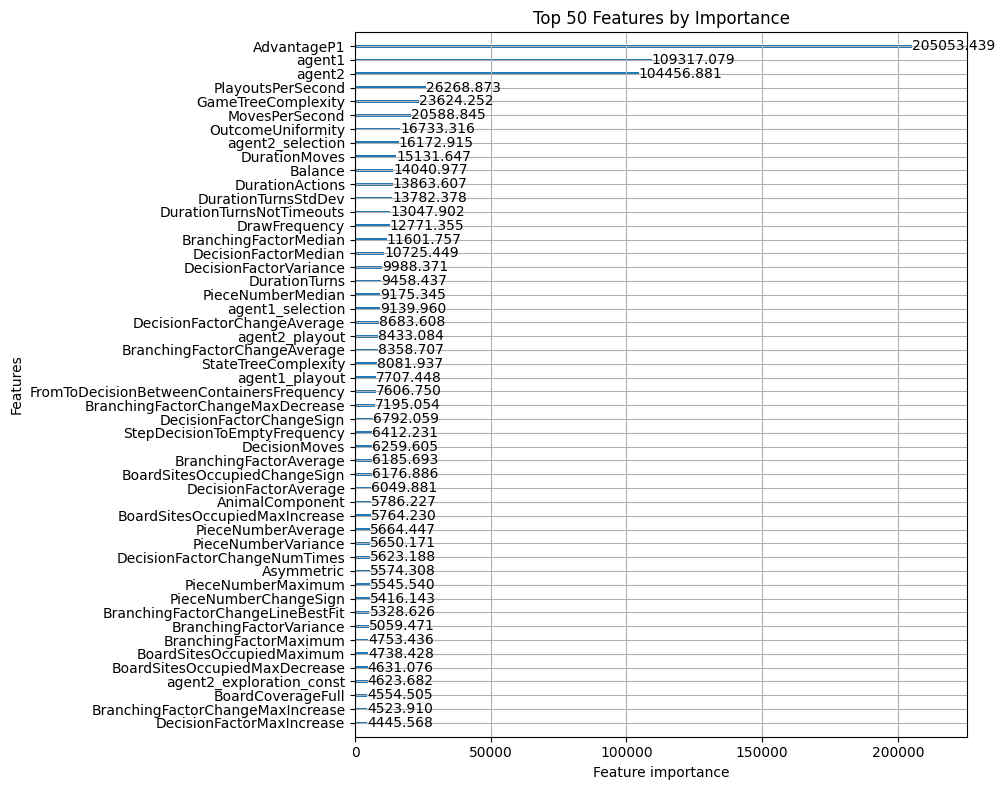

Fold 5 - RMSE: 0.43575706295413275
List of oof scores: [0.41563091622934395, 0.4077334102497926, 0.4350919995178272, 0.43291897184355554, 0.43575706295413275]
Average oof score: 0.4254264721589305


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_linear_{fs_type}_cv2.parquet', index=False)

Fold 1
[100]	valid_0's rmse: 0.502867
[200]	valid_0's rmse: 0.479801
[300]	valid_0's rmse: 0.469238
[400]	valid_0's rmse: 0.462853
[500]	valid_0's rmse: 0.458731
[600]	valid_0's rmse: 0.455992
[700]	valid_0's rmse: 0.453431
[800]	valid_0's rmse: 0.451602
[900]	valid_0's rmse: 0.45023
[1000]	valid_0's rmse: 0.449248
[1100]	valid_0's rmse: 0.448135
[1200]	valid_0's rmse: 0.447135
[1300]	valid_0's rmse: 0.446545
[1400]	valid_0's rmse: 0.44599
[1500]	valid_0's rmse: 0.445238
[1600]	valid_0's rmse: 0.444713
[1700]	valid_0's rmse: 0.444345
[1800]	valid_0's rmse: 0.443801
[1900]	valid_0's rmse: 0.443529
[2000]	valid_0's rmse: 0.443204
[2100]	valid_0's rmse: 0.442916
[2200]	valid_0's rmse: 0.442646
[2300]	valid_0's rmse: 0.442276
[2400]	valid_0's rmse: 0.442082
[2500]	valid_0's rmse: 0.441843
[2600]	valid_0's rmse: 0.441721
[2700]	valid_0's rmse: 0.441433
[2800]	valid_0's rmse: 0.441185
[2900]	valid_0's rmse: 0.440961
[3000]	valid_0's rmse: 0.440861
[3100]	valid_0's rmse: 0.440759
[3200]	valid

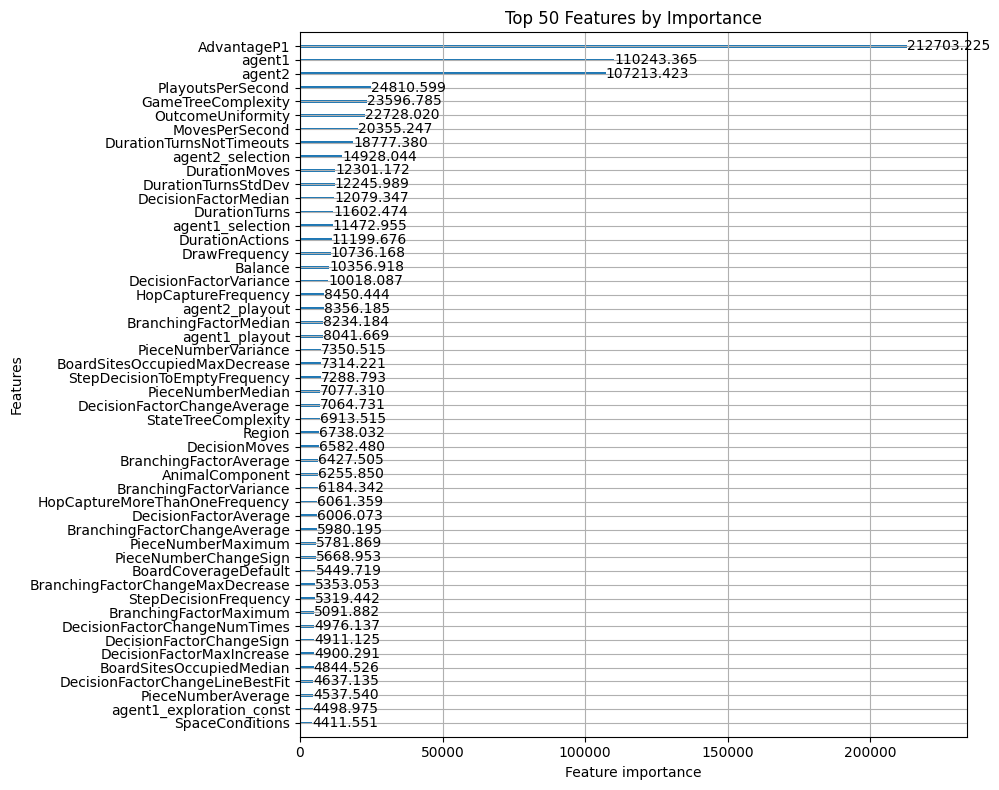

Fold 1 - RMSE: 0.43716530908389506
Fold 2
[100]	valid_0's rmse: 0.495481
[200]	valid_0's rmse: 0.472933
[300]	valid_0's rmse: 0.46031
[400]	valid_0's rmse: 0.452781
[500]	valid_0's rmse: 0.448061
[600]	valid_0's rmse: 0.444065
[700]	valid_0's rmse: 0.441058
[800]	valid_0's rmse: 0.438608
[900]	valid_0's rmse: 0.436134
[1000]	valid_0's rmse: 0.434365
[1100]	valid_0's rmse: 0.432563
[1200]	valid_0's rmse: 0.431298
[1300]	valid_0's rmse: 0.430253
[1400]	valid_0's rmse: 0.429457
[1500]	valid_0's rmse: 0.428481
[1600]	valid_0's rmse: 0.42756
[1700]	valid_0's rmse: 0.42683
[1800]	valid_0's rmse: 0.426067
[1900]	valid_0's rmse: 0.425458
[2000]	valid_0's rmse: 0.424817
[2100]	valid_0's rmse: 0.424305
[2200]	valid_0's rmse: 0.423689
[2300]	valid_0's rmse: 0.423309
[2400]	valid_0's rmse: 0.423083
[2500]	valid_0's rmse: 0.42262
[2600]	valid_0's rmse: 0.422288
[2700]	valid_0's rmse: 0.421848
[2800]	valid_0's rmse: 0.421631
[2900]	valid_0's rmse: 0.42136
[3000]	valid_0's rmse: 0.421069
[3100]	valid

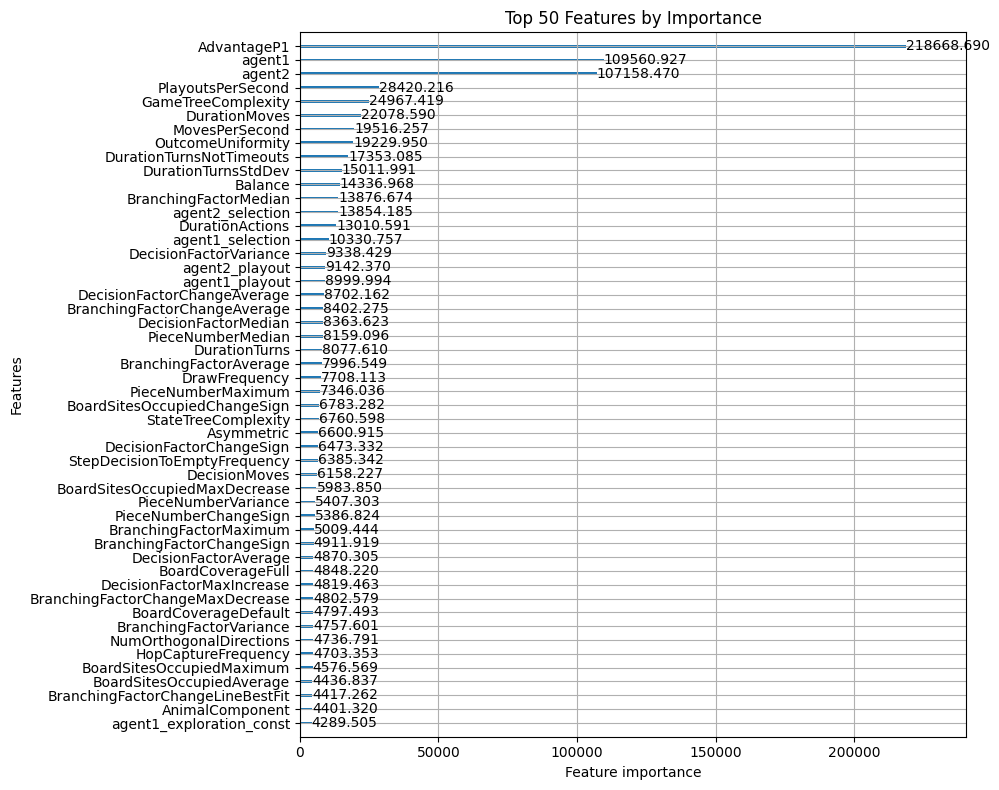

Fold 2 - RMSE: 0.4158281935530667
Fold 3
[100]	valid_0's rmse: 0.494269
[200]	valid_0's rmse: 0.475038
[300]	valid_0's rmse: 0.465508
[400]	valid_0's rmse: 0.459623
[500]	valid_0's rmse: 0.45664
[600]	valid_0's rmse: 0.453542
[700]	valid_0's rmse: 0.451261
[800]	valid_0's rmse: 0.4494
[900]	valid_0's rmse: 0.44833
[1000]	valid_0's rmse: 0.447221
[1100]	valid_0's rmse: 0.446478
[1200]	valid_0's rmse: 0.445519
[1300]	valid_0's rmse: 0.444747
[1400]	valid_0's rmse: 0.444339
[1500]	valid_0's rmse: 0.443754
[1600]	valid_0's rmse: 0.443062
[1700]	valid_0's rmse: 0.442619
[1800]	valid_0's rmse: 0.442354
[1900]	valid_0's rmse: 0.441906
[2000]	valid_0's rmse: 0.441626
[2100]	valid_0's rmse: 0.441388
[2200]	valid_0's rmse: 0.441028
[2300]	valid_0's rmse: 0.440884
[2400]	valid_0's rmse: 0.440622
[2500]	valid_0's rmse: 0.440355
[2600]	valid_0's rmse: 0.440197
[2700]	valid_0's rmse: 0.440012
[2800]	valid_0's rmse: 0.439834
[2900]	valid_0's rmse: 0.439814
[3000]	valid_0's rmse: 0.439614
[3100]	valid

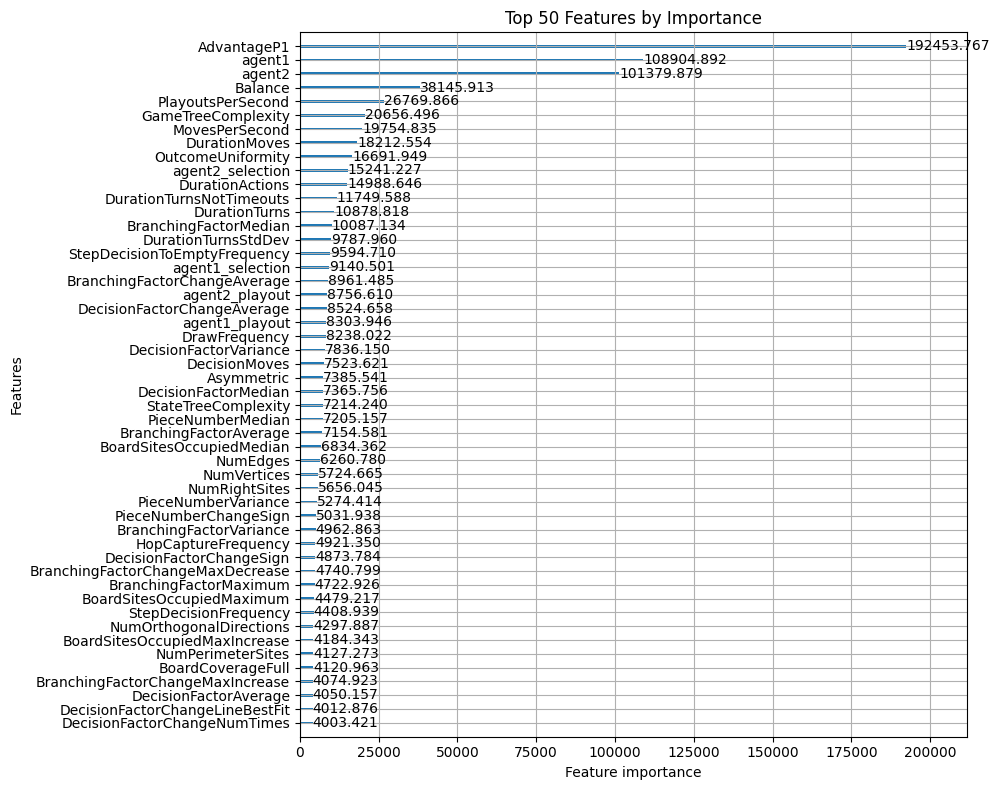

Fold 3 - RMSE: 0.435456463499904
Fold 4
[100]	valid_0's rmse: 0.485205
[200]	valid_0's rmse: 0.458679
[300]	valid_0's rmse: 0.446833
[400]	valid_0's rmse: 0.439507
[500]	valid_0's rmse: 0.435269
[600]	valid_0's rmse: 0.432633
[700]	valid_0's rmse: 0.430038
[800]	valid_0's rmse: 0.428203
[900]	valid_0's rmse: 0.426348
[1000]	valid_0's rmse: 0.424916
[1100]	valid_0's rmse: 0.423666
[1200]	valid_0's rmse: 0.422755
[1300]	valid_0's rmse: 0.422029
[1400]	valid_0's rmse: 0.421413
[1500]	valid_0's rmse: 0.420726
[1600]	valid_0's rmse: 0.420061
[1700]	valid_0's rmse: 0.419638
[1800]	valid_0's rmse: 0.419097
[1900]	valid_0's rmse: 0.418775
[2000]	valid_0's rmse: 0.418468
[2100]	valid_0's rmse: 0.418041
[2200]	valid_0's rmse: 0.417588
[2300]	valid_0's rmse: 0.417261
[2400]	valid_0's rmse: 0.417107
[2500]	valid_0's rmse: 0.416782
[2600]	valid_0's rmse: 0.416591
[2700]	valid_0's rmse: 0.416321
[2800]	valid_0's rmse: 0.416119
[2900]	valid_0's rmse: 0.415961
[3000]	valid_0's rmse: 0.415776
[3100]	va

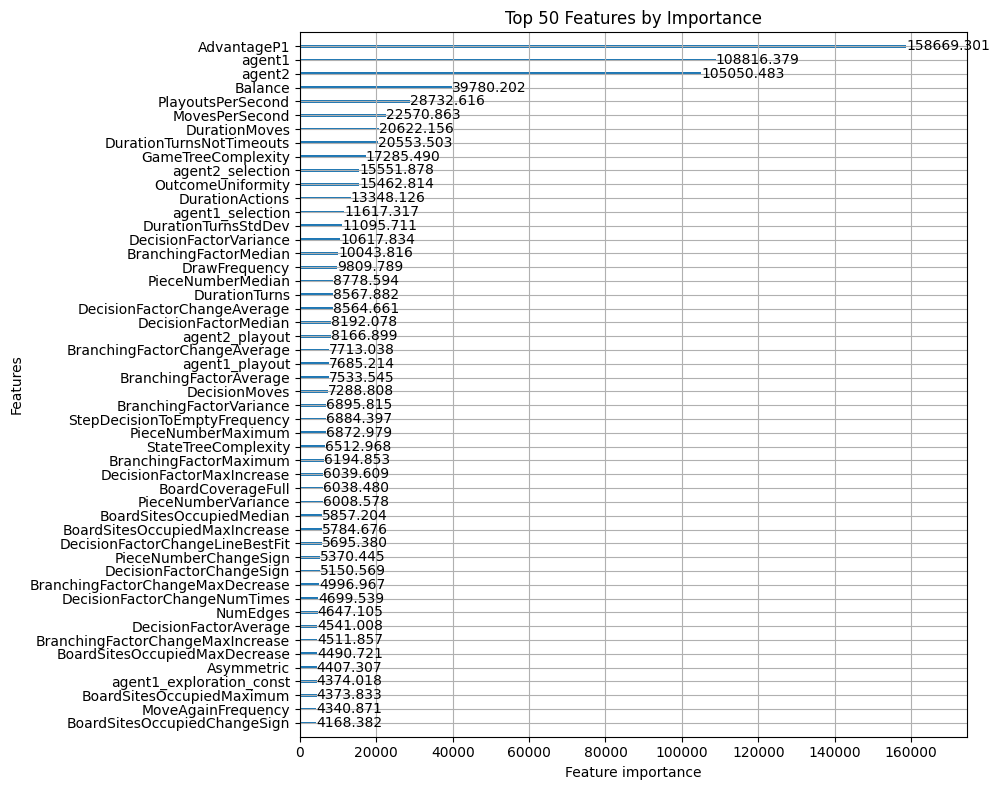

Fold 4 - RMSE: 0.41263160894676726
Fold 5
[100]	valid_0's rmse: 0.50202
[200]	valid_0's rmse: 0.483387
[300]	valid_0's rmse: 0.471476
[400]	valid_0's rmse: 0.465147
[500]	valid_0's rmse: 0.459628
[600]	valid_0's rmse: 0.455804
[700]	valid_0's rmse: 0.453092
[800]	valid_0's rmse: 0.450965
[900]	valid_0's rmse: 0.448993
[1000]	valid_0's rmse: 0.44732
[1100]	valid_0's rmse: 0.445971
[1200]	valid_0's rmse: 0.444892
[1300]	valid_0's rmse: 0.444087
[1400]	valid_0's rmse: 0.44326
[1500]	valid_0's rmse: 0.442221
[1600]	valid_0's rmse: 0.441592
[1700]	valid_0's rmse: 0.440955
[1800]	valid_0's rmse: 0.440438
[1900]	valid_0's rmse: 0.439976
[2000]	valid_0's rmse: 0.439568
[2100]	valid_0's rmse: 0.439249
[2200]	valid_0's rmse: 0.438914
[2300]	valid_0's rmse: 0.438573
[2400]	valid_0's rmse: 0.438212
[2500]	valid_0's rmse: 0.437895
[2600]	valid_0's rmse: 0.437563
[2700]	valid_0's rmse: 0.437188
[2800]	valid_0's rmse: 0.43694
[2900]	valid_0's rmse: 0.436563
[3000]	valid_0's rmse: 0.436547
[3100]	vali

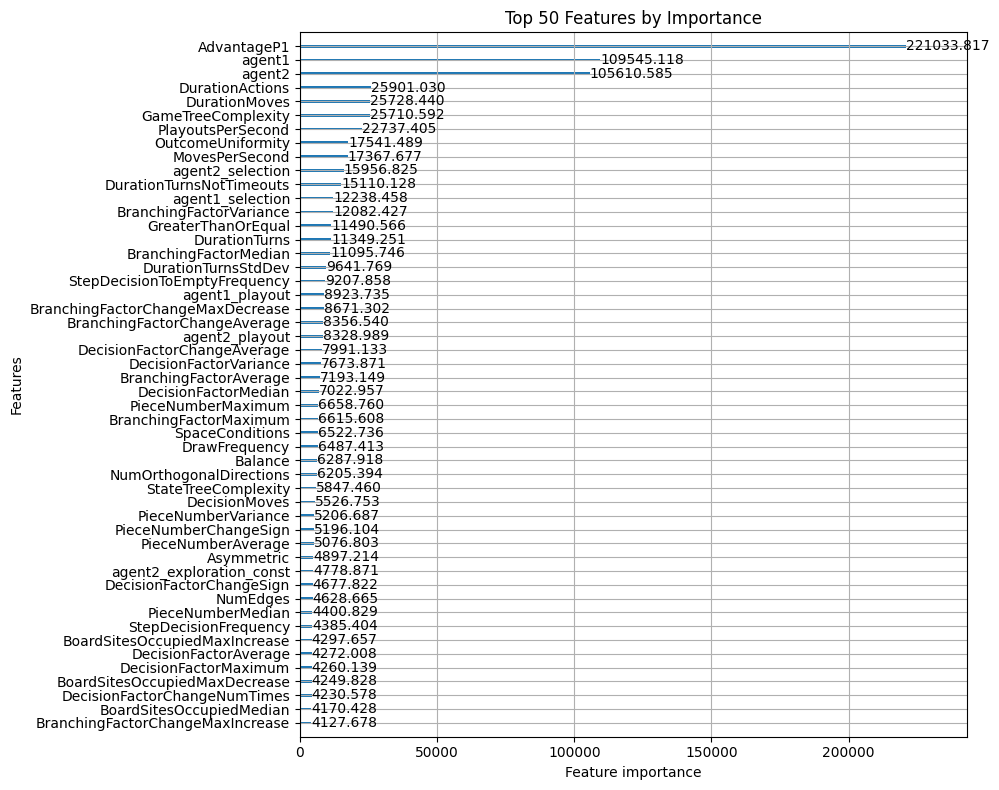

Fold 5 - RMSE: 0.4316685127488105
List of oof scores: [0.43716530908389506, 0.4158281935530667, 0.435456463499904, 0.41263160894676726, 0.4316685127488105]
Average oof score: 0.42655001756648875


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_linear_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4266
Score: 0.4508
Score: 0.4463
Score: 0.4365
Score: 0.4100
Average CV1 Score: 0.4340

CV2 OOF Scores:
Score: 0.4156
Score: 0.4077
Score: 0.4351
Score: 0.4329
Score: 0.4358
Average CV2 Score: 0.4254

CV3 OOF Scores:
Score: 0.4372
Score: 0.4158
Score: 0.4355
Score: 0.4126
Score: 0.4317
Average CV3 Score: 0.4266


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]

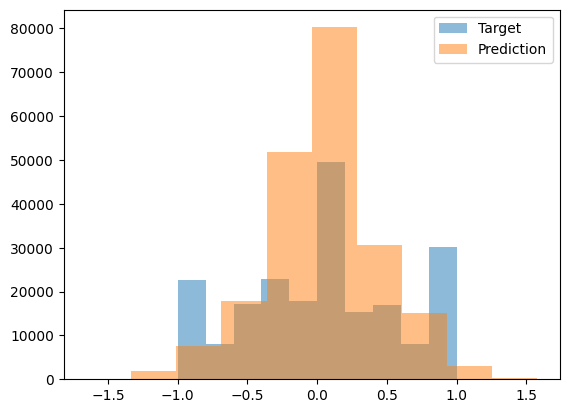

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.149463       │
│ 233235 ┆ -0.199594      │
│ 233236 ┆ 0.004744       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_linear_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***